<a href="https://colab.research.google.com/github/NkosikhonaD/WildIdentifcationDeepWild/blob/main/ProxyNCA_wits_zebra_ac_iter_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

In [ ]:
from pytorch_metric_learning import losses, miners, reducers, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [ ]:

#------------------------------imports EmbeddingNet------------------#
import torch 
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
import torchvision

import numpy as np
from numpy import mean
import torchvision.transforms as transforms
#------------------------------imports Sampler-----------------------#
from torch.utils.data.sampler import Sampler
from collections import defaultdict
import random
import torch.nn.functional as F

#------------------------------imports Dataset-----------------------#
from PIL import Image
import PIL.ImageOps

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torchvision.datasets as dset

from torch.utils.data import Dataset

import os
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
animal_root = "/content/drive/MyDrive/Zebra_img/"
root_train = animal_root+"train"
root_test = animal_root+"val"
!ls "/content/drive/MyDrive/Zebra_img/"


name_rename.csv  train	val


In [ ]:
def set_parameter_requires_grad(model,feature_extrating):
  if feature_extrating:
    for param in model.parameters():
      param.requires_grad=False

In [ ]:
def initialize_model(model_name,num_classes,feature_extrating,use_pretrained= True):
  model_ft=None
  if model_name=="resnet18":
    model_ft= models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)

  if model_name=="resnet34":
    model_ft= models.resnet34(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)

  if model_name=="resnet50":
    model_ft= models.resnet50(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
  
  if model_name=="resnet101":
    model_ft= models.resnet101(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
    
  if model_name=="resnet152":
    model_ft= models.resnet152(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
  if model_name =="VGG19":
    model_ft= models.vgg19(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs= model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
  if model_name =="VGG11":
    model_ft= models.vgg11(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs= model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
  
  if model_name =="densenet121":
    model_ft= models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs= model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs,num_classes)
  if model_name =="densenet201":
    model_ft= models.densenet201(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft,feature_extrating)
    num_ftrs= model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs,num_classes)
  return model_ft
  
  

In [ ]:
class EmbeddingNet(nn.Module):
  def __init__(self,model_name,num_classes,feature_extrating,use_pretrained):
    super(EmbeddingNet,self).__init__()
    self.backbone = model_name
    if model_name is None:
      #initialize_model(model_name,num_classes = 128,feature_extract,use_pretrained= True)
      self.backbone = models.resnet18(num_classes=128)
    else:
        self.backbone =initialize_model(model_name,num_classes,feature_extrating,use_pretrained)
    #self.backbone = backbone
  def forward(self,x):
    x=self.backbone(x)
    x= nn.functional.normalize(x,dim=1)
    return x


In [ ]:
def show_plot_two(x_axis_array1,y_axis_array1,y_axis_array2,graph_1_lab="gr1",graph_2_lab="gr2",title="set title",x_label="epoch",y_label="loss"):
  
  if len(x_axis_array1)!= len(y_axis_array1):
    ly1 =min(len(x_axis_array1),len(y_axis_array1))
    ly2 =min(len(x_axis_array1),len(y_axis_array2))
    
    plt.plot(x_axis_array1[:ly1],y_axis_array1[:ly1],label=graph_1_lab)
    plt.plot(x_axis_array1[:ly2],y_axis_array2[:ly2],label=graph_2_lab)
  else:
    plt.plot(x_axis_array1,y_axis_array1,label=graph_1_lab)
    plt.plot(x_axis_array1,y_axis_array2,label=graph_2_lab)

  plt.xlabel(x_label)
  plt.ylabel(y_label)   
  plt.title(title)
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
def show_plot(x_axis_array,y_axis_array, title="set title",x_label="set_xlabes",y_label="set_ylabels"):
  plt.plot(x_axis_array,y_axis_array)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
class OnlineTripletDataset(Dataset):
  def __init__(self,imageFolderDataset,transform=None,should_invert=True):
    self.imageFolderDataset = imageFolderDataset
    self.should_invert= should_invert
    self.transform = transform
    #self.targets = [img[1] for img in self.imageFolderDataset.imgs]
    self.targets = [name[1] for name in self.imageFolderDataset.imgs]
    self.targets = list(set(self.targets))
  def __getitem__(self,index):
    img0_tuple = random.choice(self.imageFolderDataset.imgs)
    img0 = Image.open(img0_tuple[0])
    target = img0_tuple[1]

    if self.should_invert:
      img0=PIL.ImageOps.invert(img0)
    if self.transform is not None:
      img0=self.transform(img0)
    return img0, torch.from_numpy(np.array([int(target)],dtype=np.float32))
  def __len__(self):
    return (len(self.imageFolderDataset.imgs))


In [ ]:
accuracy_list = []
embeds = []
labels= []
train_loss = []
test_loss = []
epoch_iterator = []
test_iterator = []
dists = None
targets = None

In [ ]:
def train_epoch(model,optimizer,loss_optimizer,criterion,data_loader,device,epoch,print_freq):
  model.train()
  running_loss = 0;
  running_frac_pos_triplets= 0
  epoch_iterator.append(epoch)
  for i, data in enumerate(data_loader):
    optimizer.zero_grad()
    samples, targets = data[0].to(device),data[1].to(device)
    embeddings = model(samples)
    #loss,frac_pos_triplets = criterion(embeddings,targets)
    targets = torch.flatten(targets)
    loss = criterion(embeddings,targets)
    loss.backward()
    optimizer.step()
    loss_optimizer.step()
    running_loss +=loss.item()

    #running_frac_pos_triplets+=float(frac_pos_triplets)

    if i%print_freq ==print_freq-1:
      i+=1
      avg_loss = running_loss/print_freq
      train_loss.append(avg_loss)
      
      #avg_trip =100.0*running_frac_pos_triplets/print_freq
      #print('[{:d}, {:d}] | loss: {:.4f} | % avg hard triplets: {:.2f}%'.format(epoch, i, avg_loss, avg_trip))
      print('[{:d}, {:d}] | loss: {:.4f}'.format(epoch, i, avg_loss))
      running_loss = 0
      running_frac_pos_triplets = 0

In [ ]:
def imshow(img,text=None,should_save= False):
  npimg = img.cpu().numpy()
  plt.axis("off")
  if text:
    plt.text(75,8,text,style='italic',fontweight='bold',bbox={'facecolor':'white','alpha':0.8,'pad':10})
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()
  

In [ ]:
def save(model,epoch,save_dir,file_name):
  file_name = 'epoch_'+str(epoch)+'_'+file_name
  save_path =os.path.join(save_dir,file_name)
  torch.save(model.state_dict(),save_path)

In [ ]:

folder_dataset_train = dset.ImageFolder(root=root_train)
#folder_dataset_test = dset.ImageFolder(root="/content/drive/My Drive/ColabNotebooks/DataProcessed/Nyla_Data/val")

#train_dataset = OnlineTripletDataset(imageFolderDataset=folder_dataset_train,transform=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(124),transforms.ToTensor()]),should_invert=False)
#test_dataset= OnlineTripletDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose([transforms.Resize(28),transforms.CenterCrop(124),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),should_invert=False)
train_dataset = OnlineTripletDataset(imageFolderDataset=folder_dataset_train,transform=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(124),transforms.ToTensor()]),should_invert=False) 
#train_dataset._len_()
targets = train_dataset.targets
print("Total targets = "+str(len(targets)))
train_dataloader = DataLoader(train_dataset,num_workers =2,batch_size=6)

Total targets = 45


In [ ]:
folder_dataset_test = dset.ImageFolder(root=root_test)
#folder_dataset_test = dset.ImageFolder(root="/content/drive/My Drive/ColabNotebooks/DataProcessed/Lion_Data/val")

#train_dataset = OnlineTripletDataset(imageFolderDataset=folder_dataset_train,transform=transforms.Compose([transforms.Resize(28),transforms.CenterCrop(24),transforms.ToTensor()]),should_invert=False)
test_dataset= OnlineTripletDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(124),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),should_invert=False)
#test_dataset._len_()
test_dataloader = DataLoader(test_dataset,num_workers=2,batch_size=6,shuffle=False) 

targets_test = test_dataset.targets
print("targets test ",str(len(targets_test)))
device = torch.device('cuda')


targets test  41


In [ ]:
backbone_name = ["resnet18","resnet34","resnet50","resnet101","resnet152","VGG19","VGG11","densenet121","densenet201"]
feature_extract =True
extract_or_fine_tune=["tune","extr"]
dataset_used="Zebra_img"
backbone = backbone_name[8]
mode_train =extract_or_fine_tune[feature_extract]

dim = [32,64,128,256,512]
dim_embedd=dim[1]
saved_model=backbone+mode_train+str(dim_embedd)+dataset_used+".pt"
print(saved_model)

densenet201extr64Zebra_img.pt


In [ ]:
def get_all_embeddings(dataset,model):
  tester = testers.BaseTester()
  return tester.get_all_embeddings(dataset,model)

In [ ]:
def test(test1_samples,test2_samples,model,accuracy_calculator):
  test1_embeddings,test1_labels = get_all_embeddings(test1_samples,model)
  test2_embeddings,test2_labels = get_all_embeddings(test2_samples,model)
  accuracies = accuracy_calculator.get_accuracy(test1_embeddings,test2_embeddings,np.squeeze(test1_labels),np.squeeze(test2_labels),False)
   
  print("MAP ",accuracies["mean_average_precision"],"MAP@R ",accuracies["mean_average_precision_at_r"])

In [ ]:

def test_epoch(model,criterion,loss_optimizer,data_loader,device,epoch,print_freq):
  model.eval()
  model.to(device)
  running_loss = 0;
  running_frac_pos_triplets= 0
  model_string = animal_root+"epoch_"+str(epoch)+"_"+saved_model
  model.load_state_dict(torch.load(model_string))
  test_iterator.append(epoch)
  for i, data in enumerate(data_loader):
    samples, targets = data[0].to(device),data[1].to(device)
    targets = torch.flatten(targets)
    embeddings = model(samples) 
    loss = criterion(embeddings,targets)
    loss_optimizer.step()
    running_loss +=loss.item()
    if i%print_freq ==print_freq-1:
      i+=1
      avg_loss = running_loss/print_freq
      test_loss.append(avg_loss)
      print('[{:d}, {:d}] | loss: {:.4f}'.format(epoch, i, avg_loss))
      running_loss = 0
      running_frac_pos_triplets = 0

In [ ]:
test_loss = []
test_iterator = []
device = torch.device('cuda:0')
#def __init__(self,model_name,num_classes,feature_extrating,use_pretrained):
feature_extract = True 
#using model as a feature extractor... not fineturning all layers
model = EmbeddingNet(backbone,dim_embedd,feature_extract,True)
model.to(device)
params_to_update = model.parameters()
if feature_extract:
  params_to_update= []
  for name, param in model.named_parameters():
    if param.requires_grad==True:
      params_to_update.append(param)
      print("\t",name)
else:
  for name,param in model.named_parameters():
    if param.requires_grad==True:
      print("\t",name)

print_freq = 150
criterion = losses.ProxyNCALoss(45,dim_embedd,softmax_scale=1) # hyper parameter margin can be changed
optimizer = Adam(params_to_update,lr=0.0001)
loss_optimizer = Adam(criterion.parameters(),lr=0.0001)
for epoch in range(1,31):
  print('Training...',backbone,mode_train)
  train_epoch(model,optimizer,loss_optimizer,criterion,train_dataloader,device,epoch,print_freq)
  save(model,epoch,animal_root,saved_model)

	 backbone.classifier.weight
	 backbone.classifier.bias
Training... densenet201 extr
[1, 150] | loss: 3.6656
Training... densenet201 extr
[2, 150] | loss: 3.3504
Training... densenet201 extr
[3, 150] | loss: 3.1356
Training... densenet201 extr
[4, 150] | loss: 3.0119
Training... densenet201 extr
[5, 150] | loss: 2.9237
Training... densenet201 extr
[6, 150] | loss: 2.8487
Training... densenet201 extr
[7, 150] | loss: 2.7884
Training... densenet201 extr
[8, 150] | loss: 2.7647
Training... densenet201 extr
[9, 150] | loss: 2.7222
Training... densenet201 extr
[10, 150] | loss: 2.7102
Training... densenet201 extr
[11, 150] | loss: 2.6590
Training... densenet201 extr
[12, 150] | loss: 2.6327
Training... densenet201 extr
[13, 150] | loss: 2.6222
Training... densenet201 extr
[14, 150] | loss: 2.6054
Training... densenet201 extr
[15, 150] | loss: 2.5772
Training... densenet201 extr
[16, 150] | loss: 2.5757
Training... densenet201 extr
[17, 150] | loss: 2.5589
Training... densenet201 extr
[18, 1

Testing ... densenet201 extr
[1, 40] | loss: 3.7157
Testing ... densenet201 extr
[2, 40] | loss: 3.7180
Testing ... densenet201 extr
[3, 40] | loss: 3.7339
Testing ... densenet201 extr
[4, 40] | loss: 3.7186
Testing ... densenet201 extr
[5, 40] | loss: 3.7207
Testing ... densenet201 extr
[6, 40] | loss: 3.7738
Testing ... densenet201 extr
[7, 40] | loss: 3.7372
Testing ... densenet201 extr
[8, 40] | loss: 3.7371
Testing ... densenet201 extr
[9, 40] | loss: 3.7447
Testing ... densenet201 extr
[10, 40] | loss: 3.7329
Testing ... densenet201 extr
[11, 40] | loss: 3.7403
Testing ... densenet201 extr
[12, 40] | loss: 3.7926
Testing ... densenet201 extr
[13, 40] | loss: 3.7314
Testing ... densenet201 extr
[14, 40] | loss: 3.7503
Testing ... densenet201 extr
[15, 40] | loss: 3.7509
Testing ... densenet201 extr
[16, 40] | loss: 3.7879
Testing ... densenet201 extr
[17, 40] | loss: 3.7587
Testing ... densenet201 extr
[18, 40] | loss: 3.7501
Testing ... densenet201 extr
[19, 40] | loss: 3.7620
Te

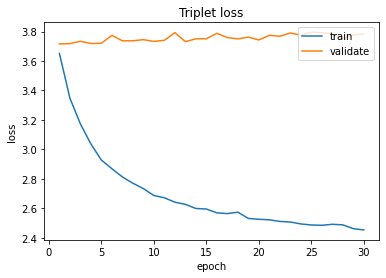

In [ ]:
feature_extract = False 
#using model as a feature extractor... not fineturning all layers
model = EmbeddingNet(backbone,dim_embedd,feature_extract,True)
#model = EmbeddingNet("VGG19",)
criterion = losses.ProxyNCALoss(41,dim_embedd,softmax_scale=1)
loss_optimizer = Adam(criterion.parameters(),lr=0.01) 
print_freq = 40
for epoch in range(1,31):
  print('Testing ...',backbone,mode_train)
  test_epoch(model,criterion,loss_optimizer,test_dataloader,device,epoch,print_freq)    
show_plot_two(test_iterator,train_loss,test_loss,"train","validate","Triplet loss")

In [ ]:
print("Evaluating model",backbone,mode_train)
test_dataset1= OnlineTripletDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(124),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),should_invert=False)
test_dataset2= OnlineTripletDataset(imageFolderDataset=folder_dataset_test,transform=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(124),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),should_invert=False)

accuracy_calculator = AccuracyCalculator(include = ("mean_average_precision","mean_average_precision_at_r",),k=None)
accuracy_calculator2 = AccuracyCalculator(include = ("mean_average_precision","mean_average_precision_at_r",),k=1)
model = EmbeddingNet(backbone,dim_embedd,False,True)
model.to(device)
model_string = animal_root+"epoch_"+str(30)+"_"+saved_model
model.load_state_dict(torch.load(model_string))
test(test_dataset1,test_dataset2,model,accuracy_calculator)
print(" ---------------   Evaluate model at k =1 --------------------------------------")
test(test_dataset1,test_dataset2,model,accuracy_calculator2)

Evaluating model densenet201 extr


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/10 [00:00<?, ?it/s]

MAP  0.37617605089030115 MAP@R  0.27975702325905527
 ---------------   Evaluate model at k =1 --------------------------------------


100%|██████████| 10/10 [00:08<00:00,  1.11it/s]

MAP  0.7876712328767123 MAP@R  0.7876712328767123


In [ ]:
mydir =animal_root
for f in os.listdir(mydir):
    if not f.endswith(".pt"):
        continue
    os.remove(os.path.join(mydir, f))